In [7]:
import pandas as pd
from scipy.stats import ttest_ind
ab = pd.read_csv("C:/Users/User/Downloads/ab_test_data.csv")
ab.head(10)

,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0
5,0c6aad3a-8068-473c-98ea-88abbcacbe67,2023-07-15 21:13:55.067827,b,0
6,397c76e4-a4db-4712-b3ce-febfb13cb634,2023-07-18 07:03:05.315509,b,0
7,9b1f084d-8a7f-4526-b859-4935ca99482c,2023-07-17 12:11:21.902593,a,0
8,37ade847-cd45-4ca7-99c6-13fe881e7f42,2023-07-24 23:35:24.243933,b,0
9,b856113a-75d4-4911-894c-4d4c75f37c34,2023-07-22 19:38:24.460128,a,0


In [11]:
co = ab.groupby(['test_group'], as_index=False).agg({ 'conversion': 'mean', 'user_id': 'count'}) # Table with conversions and sizes per group
co.head(10)

,test_group,conversion,user_id
0,a,0.061021,10013
1,b,0.089034,9985


In [12]:
begin = ab['timestamp'].min()    #Dates of beginning and end of A/B test
end = ab['timestamp'].max()
date_begin = pd.to_datetime(begin).date()
date_end = pd.to_datetime(end).date()
print(f"Begin - {date_begin}")
print(f"End - {date_end}")

Begin - 2023-07-03
End - 2023-07-25


In [45]:
from datetime import timedelta # How many days was held this A/B test?
time = (date_end - date_begin) + timedelta(days=1) # Add 1 day because of subtracting principe - when subtracting the start date from the end date, the start date is not included in the result
print(f"Time of A/B testing - {time}")      


Time of A/B testing - 23 days, 0:00:00


In [15]:
a = ab[ab['test_group'] == 'a']['conversion']  #separaing CR for each group
b = ab[ab['test_group'] == 'b']['conversion']

In [17]:
t_stat, p_value = ttest_ind(a, b, equal_var = False) #Calculating p-value (the probability if the null hypothesis (The new design has no effect on conversion) is true) of A/B test by Student's t-test
print(f"T-stats: {t_stat}")
print(f"P-value: {p_value}")

T-stats: -7.528139567322235
P-value: 5.371629545263574e-14


In [41]:
alpha = 0.05 # Statistical significance (the largest allowing probability of the rejecting the null hypothesis, when the null hypothesis is true)
if p_value < alpha:
    print("We embrace the null hypothesis, but we will check it using z-test.")
else:
    print("We do not reject the null hypothesis.")

We embrace the null hypothesis, but we will check it using z-test.


In [39]:
from statsmodels.stats.proportion import proportions_ztest # Checking the results using the z-test
a_conv = ab[ab['test_group'] == 'a']['conversion'].sum()
b_conv = ab[ab['test_group'] == 'b']['conversion'].sum()
size_a = ab[ab['test_group'] == 'a'].shape[0]
size_b = ab[ab['test_group'] == 'b'].shape[0]
conv = [a_conv, b_conv]
sizes = [size_a, size_b]
z_stat, p_value = proportions_ztest(conv, sizes)
print(f"Z-статистика: {z_stat}")
print(f"P-значення: {p_value}")
alpha = 0.05
if p_value < alpha:
    print("Both t-test and z-test results are equal. We finally embrace the null hypothesis.")
else:
    print("We do not reject the null hypothesis.")

Z-статистика: -7.519675939906207
P-значення: 5.491217728445103e-14
Both t-test and z-test results are equal. We finally embrace the null hypothesis.


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

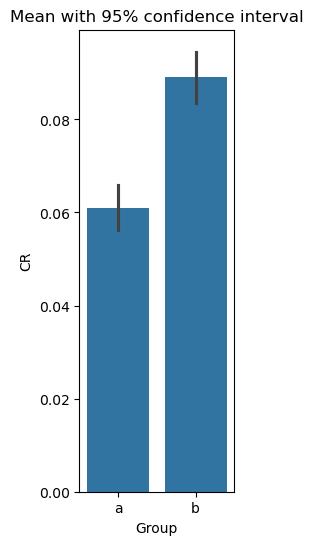

In [49]:
plt.figure(figsize = (2, 6)) # Chart of CR with 95% сonfidence interval for report
sns.barplot( 
    data = ab,
    x = 'test_group',
    y = 'conversion',
    errorbar=('ci', 95)
)

plt.title('Mean with 95% сonfidence interval')
plt.xlabel('Group')
plt.ylabel('CR')
plt.show()

In [37]:
ab['timestamp'] = pd.to_datetime(ab['timestamp']) # Creating a table with CR total & CR by groups for each day (for chart below)
ab['date'] = ab['timestamp'].dt.date
conversion_over_time = ab.groupby(['date', 'test_group']).agg(
    mean_conversion=('conversion', 'mean'))

total_conversion = ab.groupby('date').agg(
    mean_conversion=('conversion', 'mean')
).reset_index()
conversion_a = ab[ab['test_group'] == 'a'].groupby('date')['conversion'].mean().reset_index()
conversion_b = ab[ab['test_group'] == 'b'].groupby('date')['conversion'].mean().reset_index()

total_conversion = total_conversion.merge(conversion_a.rename(columns={'conversion':'c_a'}), how = 'left', on = 'date').merge(conversion_b.rename(columns={'conversion':'c_b'}), how = 'left', on = 'date')

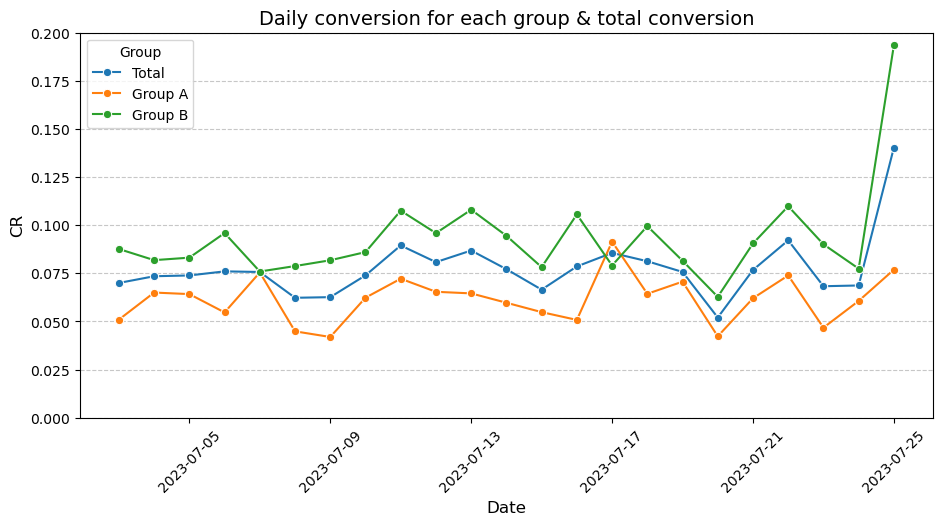

In [48]:
plt.figure(figsize = (11, 5)) # Chart with CR by group and total for each day
sns.lineplot(data= total_conversion, x='date', y='mean_conversion', label='Total', marker='o')
sns.lineplot(data= total_conversion, x='date', y='c_a', label='Group A', marker='o')
sns.lineplot(data= total_conversion, x='date', y='c_b', label='Group B', marker='o')

plt.title('Daily conversion for each group & total conversion', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CR', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 0.2)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Group', fontsize=10)
plt.show()
